Anastasia Solomatina

Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge 

https://www.leibniz-hki.de/en/applied-systems-biology.html 

HKI-Center for Systems Biology of Infection Leibniz Institute for Natural Product Research and Infection Biology - Hans Knöll Insitute (HKI) 

Adolf-Reichwein-Straße 23, 07745 Jena, Germany

This code is licensed under BSD 2-Clause 

See the LICENSE file provided with this code for the full license.

In [1]:
import python_sbm as ps
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns

from matplotlib.ticker import MultipleLocator

### Load data

In [2]:
# ABC results
fname = 'PYABC_sbm'
abc_data = az.from_netcdf('abc_data/'+fname+'.nc')

In [3]:
# Load experimental data
path = '../data/whole_expData.dat'
names = ['Time', 'C_N', 'C_M', 'C_E', 'C_A']
df = pd.read_csv(path, sep='\t', header=None, names=names)

# Compute C_K killed population
df['C_K'] = (100 - df['C_A']).clip(lower=0)

cols = ['C_A', 'C_K', 'C_M', 'C_N', 'C_E']
df[cols] = df[cols]/100

mean_df = df.groupby('Time', as_index=False)[cols].mean()
std_df = df.groupby('Time', as_index=False)[cols].std()
std_df = std_df.rename(columns={c: f'sd_{c}' for c in cols})
data_exp = pd.merge(mean_df, std_df, on='Time')

# Extracellular population for predecorated experiment at time = 60 mins
fold_increase = 1.57
CE_EVCa = df.loc[df['Time'] == 60,'C_E'].values*fold_increase

print(data_exp.head())

   Time     C_A     C_K     C_M     C_N     C_E    sd_C_A    sd_C_K    sd_C_M  \
0     0  1.0000  0.0000  0.0000  0.0000  1.0000  0.000000  0.000000  0.000000   
1    10  0.7534  0.2466  0.0198  0.5166  0.4636  0.067671  0.067671  0.006834   
2    20  0.5012  0.4988  0.0290  0.7232  0.2478  0.075965  0.075965  0.008337   
3    40  0.3734  0.6266  0.0478  0.8360  0.1162  0.096914  0.096914  0.012988   
4    60  0.3766  0.6234  0.0512  0.8548  0.0940  0.067719  0.067719  0.007155   

     sd_C_N    sd_C_E  
0  0.000000  0.000000  
1  0.103355  0.105175  
2  0.098446  0.099550  
3  0.080632  0.076917  
4  0.056531  0.055502  


In [4]:
def model(params):
    rates = dict()
    shift = 3
    rates['PhiM']=10**(params[5]-shift)
    rates['KappaG']=10**(params[2]-shift)
    rates['KappaM']=10**(params[3]-shift)
    rates['Rho']=10**(params[6]-shift)
    rates['Gamma']=10**(params[0]-shift)
    rates['KappaExt']=10**(params[1]-shift)
    
    cells = dict()
    size = 1e+03
    cells['ALIVEEXTERNCANDIDA'] = size
    cells['MONOCYTES'] = 0.5*size
    cells['GRANULOCYTES'] = 5*size
    cells['DECORATED'] = 0

    # untreated C.a. population
    rates['PhiG']=10**(params[4]-shift)
    rates['PhiGStar']=10**(params[4]-shift)
    
    temp = ps.run_sbm(1,0.5,481,cells,rates,True)
    out1 = np.copy(temp[0, :, :])

    # predecorated C.a. population
    rates['PhiG']=10**(params[7]-shift)
    rates['PhiGStar']=10**(params[7]-shift)
    
    temp = ps.run_sbm(1,0.5,481,cells,rates,True)
    out2 = np.copy(temp[0, :, :])

    out = np.concatenate((out1[:, [0, 1, 3, 4, 2]], out2[:, [0, 1, 3, 4, 2]]), axis=1)

    return out

In [5]:
def model_dec(params):
    rates = dict()
    sh = 3
    rates['PhiG']=10**(params[7]-sh)
    rates['PhiGStar']=10**(params[7]-sh)
    rates['PhiM']=10**(params[5]-sh)
    rates['KappaG']=10**(params[2]-sh)
    rates['KappaM']=10**(params[3]-sh)
    rates['Rho']=10**(params[6]-sh)
    rates['Gamma']=10**(params[0]-sh)
    rates['KappaExt']=10**(params[1]-sh)
    
    cells = dict()
    size = 1e+03
    cells['ALIVEEXTERNCANDIDA'] = size
    cells['MONOCYTES'] = 0.5*size
    cells['GRANULOCYTES'] = 5*size
    cells['DECORATED'] = 0
    output = ps.run_sbm(1,0.5,481,cells,rates,True)
    
    temp = np.copy(output[0, :, :])
    
    return temp[:,[ 0, 1, 3, 4, 2]]

In [6]:
list_params = list(abc_data.posterior.data_vars.keys())
list_params

['Gamma', 'KappaExt', 'KappaN', 'KappaM', 'PhiN', 'PhiM', 'Rho', 'PhiND']

In [7]:
par_lbls = ['$\gamma$', '$\kappa_{EK}$', '$\kappa_N$', '$\kappa_M$', '$\phi_N$', '$\phi_M$', r'$\rho$','$\phi_{ND}$']

In [8]:
# Draw randomly parameters from the distributions and run simulations
num_draws = 100
list_d = list()
params_d = list()
times = np.arange(0,481,1)
for i in range(num_draws):
    params = []
    for name in list_params:
        params.append(abc_data.posterior.sel(chain=1,draw=10+i)[name].values)
    
    conc1 = (pd.DataFrame(model(params))
        .rename(columns={integer: string for integer,string in list(zip(np.arange(10),['C_A','C_K','C_M','C_N','C_E','C_AD','C_KD','C_MD','C_ND','C_ED']))})
        .assign(Time = times))
    conc1['Time'] = np.arange(0,240.5,0.5)
    list_d.append(conc1)
    params_d.append(params)

In [9]:
# Concatenate the list of dataframes and reshape it into long format
sim_df = pd.concat(list_d).melt(id_vars=['Time'], var_name='Population', value_name='Concentration')

# Initialize the output dataframe with unique time points
data_sim = sim_df[['Time']].drop_duplicates().sort_values(by='Time').reset_index(drop=True)

populations = ['C_A','C_K','C_M','C_N','C_E','C_AD','C_KD','C_MD','C_ND','C_ED']
# Process each unique population dynamically
for population in populations:
    mean_concentration = sim_df[sim_df['Population'] == population].groupby('Time')['Concentration'].mean().reset_index()
    std_concentration = sim_df[sim_df['Population'] == population].groupby('Time')['Concentration'].std().reset_index()
    
    data_sim = data_sim.merge(mean_concentration, on='Time', how='left')
    data_sim.rename(columns={'Concentration': population}, inplace=True)
    
    data_sim = data_sim.merge(std_concentration, on='Time', how='left')
    data_sim.rename(columns={'Concentration': f'sd_{population}'}, inplace=True)

In [10]:
data_sim

,Time,C_A,sd_C_A,C_K,sd_C_K,C_M,sd_C_M,C_N,sd_C_N,C_E,...,C_AD,sd_C_AD,C_KD,sd_C_KD,C_MD,sd_C_MD,C_ND,sd_C_ND,C_ED,sd_C_ED
0,0.0,1.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,1.00000,...,1.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,1.00000,0.000000
1,0.5,0.99966,0.000590,0.00034,0.000590,0.00195,0.001336,0.03314,0.005731,0.96491,...,0.99972,0.000533,0.00028,0.000533,0.00207,0.001343,0.02140,0.005937,0.97653,0.006079
2,1.0,0.99493,0.002253,0.00507,0.002253,0.00386,0.001933,0.06402,0.008014,0.93212,...,0.99637,0.002277,0.00363,0.002277,0.00398,0.002188,0.04258,0.009315,0.95344,0.009821
3,1.5,0.98645,0.004312,0.01355,0.004312,0.00565,0.002603,0.09548,0.010120,0.89887,...,0.99058,0.004269,0.00942,0.004269,0.00601,0.002769,0.06352,0.013057,0.93047,0.013528
4,2.0,0.97484,0.005761,0.02516,0.005761,0.00728,0.002882,0.12417,0.011976,0.86855,...,0.98269,0.006488,0.01731,0.006488,0.00762,0.003054,0.08407,0.017480,0.90831,0.017922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,238.0,0.15395,0.022604,0.84605,0.022604,0.05137,0.008899,0.85778,0.019208,0.09085,...,0.15391,0.020784,0.84609,0.020784,0.07379,0.014476,0.80123,0.025447,0.12498,0.019309
477,238.5,0.15357,0.022579,0.84643,0.022579,0.05137,0.008899,0.85778,0.019208,0.09085,...,0.15358,0.020702,0.84642,0.020702,0.07379,0.014476,0.80123,0.025447,0.12498,0.019309
478,239.0,0.15317,0.022552,0.84683,0.022552,0.05137,0.008899,0.85778,0.019208,0.09085,...,0.15325,0.020665,0.84675,0.020665,0.07379,0.014476,0.80123,0.025447,0.12498,0.019309
479,239.5,0.15278,0.022518,0.84722,0.022518,0.05137,0.008899,0.85778,0.019208,0.09085,...,0.15301,0.020668,0.84699,0.020668,0.07379,0.014476,0.80123,0.025447,0.12498,0.019309


### Figure 7 A

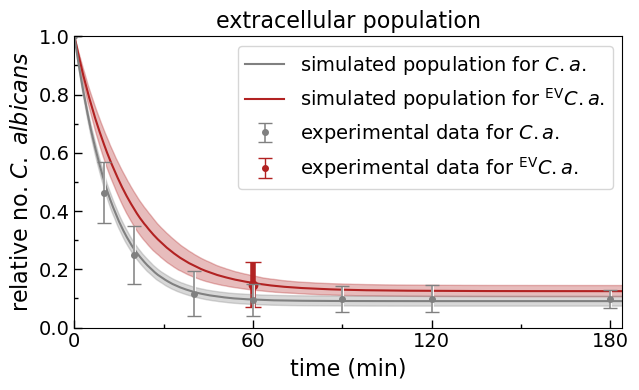

In [11]:
times_plotting = [0,10,20,40,60,90,120,180]

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(data_sim['Time'], data_sim['C_E'],color = 'gray',linewidth = 1.5, zorder=2, label = 'simulated population for $C. a.$')
ax.fill_between(data_sim['Time'],data_sim['C_E']-data_sim['sd_C_E'],
                         data_sim['C_E']+data_sim['sd_C_E'],color = 'gray', alpha=0.3, zorder=2)
(_, caps, bars) = ax.errorbar(times_plotting, data_exp['C_E'], yerr=data_exp['sd_C_E'], fmt='o', linewidth = 1.1,
                         capsize=5, markersize=4, color='gray', zorder=2,label='experimental data for $C. a.$')

for bar in bars:
    bar.set_path_effects([pe.Stroke(linewidth=2, foreground='white'), pe.Normal()])

ax.plot(data_sim['Time'], data_sim['C_ED'],color = 'firebrick',linewidth = 1.5, zorder=1, label = 'simulated population for $^{\mathrm{EV}} C. a.$')
ax.fill_between(data_sim['Time'],data_sim['C_ED']-data_sim['sd_C_ED'],
                         data_sim['C_ED']+data_sim['sd_C_ED'], color = 'firebrick', alpha=0.3, zorder=1)
ax.errorbar(60, CE_EVCa.mean(), yerr=CE_EVCa.std(), fmt='o', 
                         capsize=6, markersize=6, color='firebrick', zorder=1,linewidth = 4)
ax.errorbar(1600, CE_EVCa.mean(), yerr=CE_EVCa.std(), fmt='o', 
                         capsize=5, markersize=4, color='firebrick', zorder=1,linewidth = 1,label='experimental data for $^{\mathrm{EV}} C. a.$')

ax.set_xlabel('time (min)',fontsize = 16)
ax.set_ylabel('relative no. $C.$ $albicans$',fontsize = 16)

ax.xaxis.set_major_locator(MultipleLocator(60))
ax.xaxis.set_minor_locator(MultipleLocator(30))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.tick_params(which='major', length=6, width=1, direction='in', labelsize=14)
ax.tick_params(which='minor', length=3, width=1, direction='in')
ax.set_xlim(0,184)
ax.set_ylim(0,1)

ax.legend(fontsize=14)

plt.rcParams.update({
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,  'xtick.bottom': True,
    'ytick.left': True, 'ytick.right': True,
})

ax.set_title('extracellular population',fontsize=16)

fig.tight_layout()

plt.show()

### Figure S6

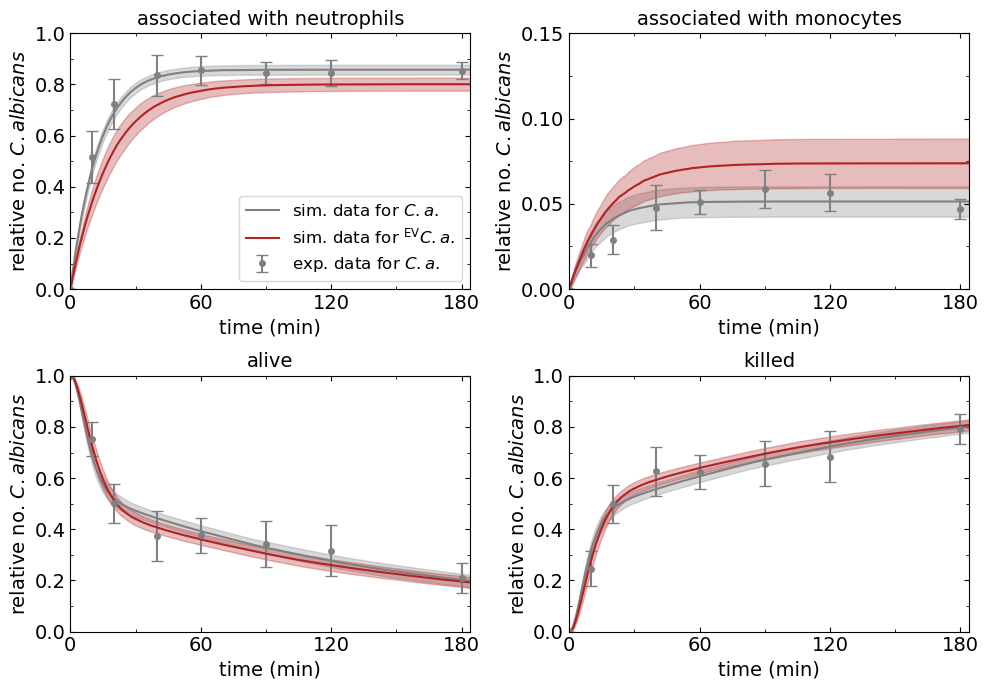

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

col_untreat = ['C_N','C_M','C_A','C_K']
col_predec = [f'{s}D' for s in col_untreat]
sd_col_untreat = [f'sd_{s}' for s in col_untreat]
sd_col_predec = [f'sd_{s}' for s in col_predec]
titles = ['associated with neutrophils','associated with monocytes','alive','killed']

for i in range(4):
    axes[i].errorbar(data_exp['Time'], data_exp[col_untreat[i]], yerr=data_exp[sd_col_untreat[i]], fmt='o', 
                         capsize=4, markersize=4, color='gray',label='exp. data for $C. a.$')
    
    axes[i].plot(data_sim['Time'], data_sim[col_untreat[i]],color = 'gray',label='sim. data for $C. a.$')
    axes[i].fill_between(data_sim['Time'],data_sim[col_untreat[i]]-data_sim[sd_col_untreat[i]],
                         data_sim[col_untreat[i]]+data_sim[sd_col_untreat[i]],color = 'gray',alpha=0.3)

    axes[i].plot(data_sim['Time'], data_sim[col_predec[i]],color = 'firebrick',label='sim. data for $^{\mathrm{EV}} C. a.$')
    axes[i].fill_between(data_sim['Time'],data_sim[col_predec[i]]-data_sim[sd_col_predec[i]],
                         data_sim[col_predec[i]]+data_sim[sd_col_predec[i]],color = 'firebrick',alpha=0.3)

    axes[i].xaxis.set_major_locator(MultipleLocator(60))
    axes[i].xaxis.set_minor_locator(MultipleLocator(30))
    if i==1:
        axes[i].yaxis.set_major_locator(MultipleLocator(0.05))
        axes[i].yaxis.set_minor_locator(MultipleLocator(0.025))
    else:
        axes[i].yaxis.set_major_locator(MultipleLocator(0.2))
        axes[i].yaxis.set_minor_locator(MultipleLocator(0.1))

    axes[i].tick_params(labelsize=14)
    axes[i].set_xlim(0,184)
    
    if i==1:
        axes[i].set_ylim(0,0.15)
    else:
        axes[i].set_ylim(0,1)
    axes[i].set_title(titles[i], fontsize = 14)

    if i==0:
        axes[i].legend(fontsize=12)

    axes[i].set_xlabel('time (min)',fontsize = 14)
    axes[i].set_ylabel(f'relative no. $C. albicans$',fontsize = 14)#\\ {{{col_name[i]}}}$')

plt.tight_layout()

plt.show()

### Plot the posterior distributions

#### Multivariate mode computation

In [13]:
from sklearn.neighbors import KernelDensity

def estimate_mode_kde(data, bandwidth="scott", grid_size=1000):

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data)
    log_dens = kde.score_samples(data)

    mode_index = np.argmax(log_dens)
    mode_point = data[mode_index]

    return mode_point

In [14]:
point_cloud = []
for it, par_nam in enumerate(list_params):
    data = abc_data.posterior[par_nam].sel(chain=0)
    point_cloud.append(data.values)

point_cloud = np.array(point_cloud)

In [15]:
mode_nD = estimate_mode_kde(point_cloud.T)
mode_nD = mode_nD - 3

In [16]:
print('The modes of the posterios are:')
for it in range(len(list_params)):
    print(list_params[it],': ','{:.3f}'.format(10**mode_nD[it]), ', ', '{:.3f}'.format(mode_nD[it]))

The modes of the posterios are:
Gamma :  0.006 ,  -2.204
KappaExt :  1.133 ,  0.054
KappaN :  0.008 ,  -2.116
KappaM :  0.190 ,  -0.722
PhiN :  0.086 ,  -1.064
PhiM :  0.050 ,  -1.305
Rho :  0.009 ,  -2.067
PhiND :  0.053 ,  -1.272


### Figure 7 B

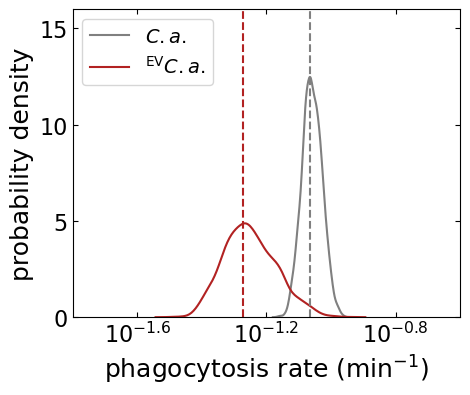

In [17]:
clr1 = 'gray'#default_colors[7]
clr2 = 'firebrick'#'darkred'#default_colors[3]

delta = 0.27
fs=14
params_name = list_params

fig, ax = plt.subplots(figsize=(5, 4))
par_nam = params_name[0]

data_init = abc_data.posterior['PhiN'].sel(chain=0)
sns.kdeplot(data_init-3, ax=ax, fill=False, clip=(-3, 0),color=clr1,label='$C.a.$')

data = abc_data.posterior['PhiND'].sel(chain=0)
sns.kdeplot(data-3, ax=ax, fill=False, clip=(-3, 0),color=clr2,label='$^{\mathrm{EV}} C.a.$')

ax.set_xlabel('phagocytosis rate (min$^{-1}$)',fontsize=18)
ax.set_ylabel('probability density',fontsize=18)
ax.tick_params(labelsize=16)
ax.set_ylim(0,16)

ax.axvline(mode_nD[4], color=clr1, linestyle='--')
ax.axvline(mode_nD[7], color=clr2, linestyle='--')

ax.set_xlim([-1.8,-0.6])
ax.set_xticks([-1.6, -1.2, -0.8], ['$10^{-1.6}$', '$10^{-1.2}$', '$10^{-0.8}$'],fontsize=16) 
ax.legend(fontsize=14, loc='upper left')

plt.show()    

### Figure S6 B

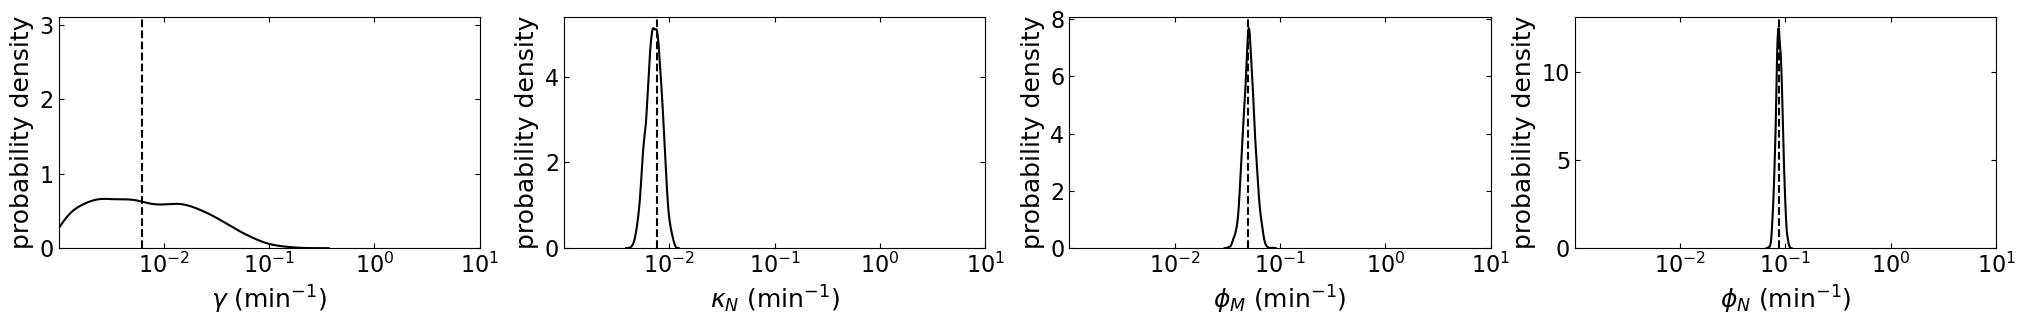

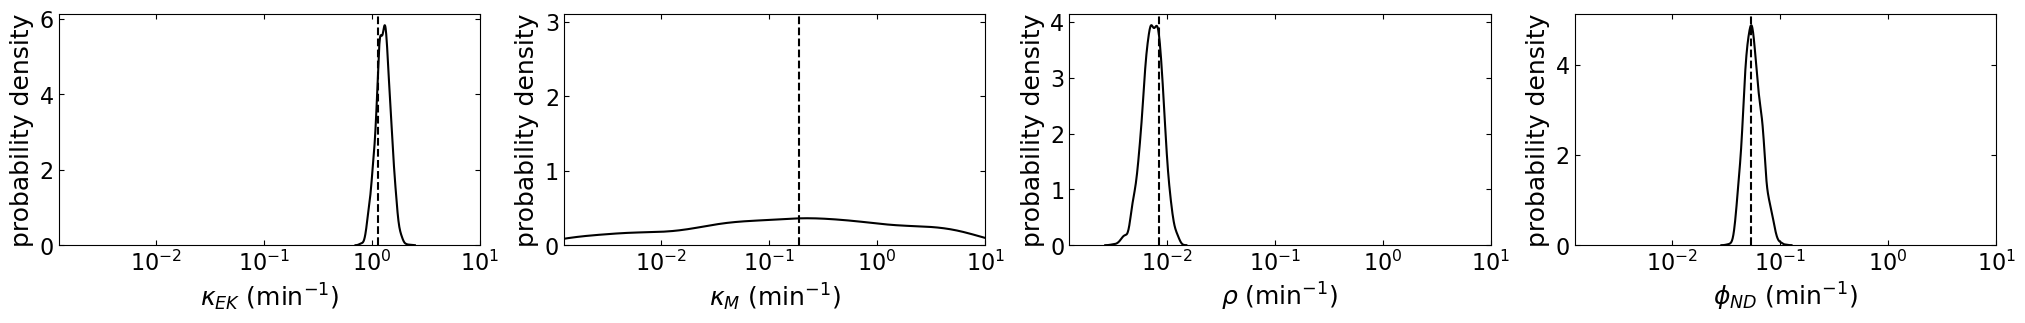

In [18]:
delta = 0.27
fs=18
params_name = ['Gamma','KappaN','PhiM','PhiN', 'KappaExt','KappaM', 'Rho', 'PhiND']
order = [0,2,5,4,1,3,6,7]
par_lbls2 = ['$\gamma$', '$\kappa_N$','$\phi_M$','$\phi_N$','$\kappa_{EK}$', '$\kappa_M$', r'$\rho$','$\phi_{ND}$']

fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(25,3))
i = 0
for ax in axes:
    if i<len(params_name):
        par_nam = params_name[i]
        
        data = abc_data.posterior[par_nam].sel(chain=0)
        sns.kdeplot(data-3, ax=ax, fill=False, clip=(-3, 1),label='Posterior distributions',color='k')
        
        ax.set_xlabel(par_lbls2[i]+' (min$^{-1}$)',fontsize=fs)
        ax.set_ylabel('probability density',fontsize=fs)
        ax.set_xlim(-3,1)

        if i==0:
            ax.set_ylim(0,3.1)

        ax.axvline(mode_nD[order[i]],color='k',linestyle='--')

        ax.set_xticks([-2, -1, 0, 1], ['$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'],fontsize=fs-2) 
        ax.tick_params(axis='y', labelsize=fs-2)
    
    i += 1  

fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(25,3))
for ax in axes:
    if i<len(params_name):
        par_nam = params_name[i]
        
        data = abc_data.posterior[par_nam].sel(chain=0)
        sns.kdeplot(data-3, ax=ax, fill=False, clip=(-3, 1),color='k')
            
        ax.set_xlabel(par_lbls2[i]+' (min$^{-1}$)',fontsize=fs)
        ax.set_ylabel('probability density',fontsize=fs)
        ax.set_xlim(-2.9,1)

        if i==5:
            ax.set_ylim(0,3.1)

        ax.axvline(mode_nD[order[i]],color='k',linestyle='--')
        
        ax.set_xticks([-2, -1, 0, 1], ['$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'],fontsize=fs-2) 
        ax.tick_params(axis='y', labelsize=fs-2)
        
    i += 1    

In [19]:
print('PhiN median:',10**(mode_nD[4]))
print('PhiND median:',10**(mode_nD[7]))
print('Ratio PhiN/PhiND: ', 10**(mode_nD[4])/10**(mode_nD[7]))
print('Ratio PhiND/PhiN: ', 10**(mode_nD[7])/10**(mode_nD[4]))

PhiN median: 0.08628302468315077
PhiND median: 0.05343464125881609
Ratio PhiN/PhiND:  1.6147394770600259
Ratio PhiND/PhiN:  0.6192949477030878
